# Land Use Analyzer

## Import the libraries

In [1]:
import geopandas as gpd
import pandas as pd
import os
from numpy import log,array,unique
from matplotlib import pyplot as plt

In [32]:
lu=gpd.read_file(input("Path to the land use dataset: "))
grid=gpd.read_file(input("Path to the grid dataset: "))
uid_lc=input("LC UID: ")
uid_grid=input("GRID UID: ")
temp_path=input("Temp path: ")

Path to the land use dataset: C://Users//avouk//Documents//LUM-entropy-project//data//SLUPShapefiles2019//SLUP2019.shp
Path to the grid dataset: C://Users//avouk//Documents//LUM-entropy-project//data//nbrhds_wards//Neighborhood_Boundaries.shp
LC UID: SLUP_LATES
GRID UID: NHD_NUM
Temp path: C://Users//avouk//Documents//LUM-entropy-project//data//temp


## Set the path to the input data

In [3]:
lu=gpd.read_file(r"C:\path...\to...\dummy_data\SLUPShapefiles2019\SLUP2019.shp")
grid=gpd.read_file(r"C:\path...\to...\dummy_data\SLUPShapefiles2019\Neighborhood_Boundaries.shp")
uid_lc="SLUP_LATES"
uid_grid="NHD_NUM"
temp_path=r"C:\Users\avouk\Documents\LUM-entropy-project\temp"

DriverError: C:\path...\to...\dummy_data\SLUPShapefiles2019\SLUP2019.shp: No such file or directory

In [4]:
lu=gpd.read_file(r"C:\Users\avouk\Documents\LUM-entropy-project\dummy_data\SLUPShapefiles2019\SLUP2019.shp")
grid=gpd.read_file(r"C:\Users\avouk\Documents\LUM-entropy-project\dummy_data\SLUPShapefiles2019\Neighborhood_Boundaries.shp")
uid_lc="SLUP_LATES"
uid_grid="NHD_NUM_ST"
temp_path=r"C:\Users\avouk\Documents\LUM-entropy-project\temp"

## Define the class for the land use mix indices

In [5]:
class lum:
    def __init__(self,lu,grid,uid_lc,uid_grid,temp_path):
        self.lu = lu
        self.grid = grid
        self.uid_lc = uid_lc
        self.uid_grid = uid_grid
        self.temp_path = temp_path
    
    def intermediate(self):
        intersection = gpd.overlay(self.lu,self.grid,how = 'intersection')
        dissolved = intersection.dissolve(by = [self.uid_lc,self.uid_grid])
    
        dissolved['poly_area'] = dissolved.area
        dissolved.to_file(os.path.join(self.temp_path,"dissolved.shp"))
    
        dissolved_new = gpd.read_file(os.path.join(self.temp_path,"dissolved.shp"))
        area_sum = dissolved_new[[self.uid_grid, "poly_area"]].groupby(self.uid_grid).sum()
    
        dissolved_new = dissolved_new.merge(area_sum, on = self.uid_grid)
        dissolved_new.rename(columns = {'poly_area_y':'total_area_cell'}, inplace = True) 
    
        ratios = (dissolved_new["poly_area_x"]/dissolved_new["total_area_cell"])
        
        num_classes_per_grid_feature = dissolved_new[[self.uid_grid, uid_lc]].groupby(self.uid_grid).count()
        
        return dissolved_new,ratios,num_classes_per_grid_feature,intersection
    
    def entropy(self):
        dataset = self.intermediate()[0]
        ratios_c = self.intermediate()[1]
        nuclapegrif=self.intermediate()[2]
        
        log_ratios = log(ratios_c)
        dataset['area_perc_log'] = log_ratios*ratios_c
        
        ln_num_classes_per_grid_feature = log(nuclapegrif)
        
        sum_logs = dataset[[self.uid_grid, "area_perc_log"]].groupby(self.uid_grid).sum()
        
        sum_logs_merged_ln_num_classes = sum_logs.merge(ln_num_classes_per_grid_feature,on = self.uid_grid)
        
        sum_logs_merged_ln_num_classes['ENTROPY'] = -1*(sum_logs_merged_ln_num_classes['area_perc_log']/sum_logs_merged_ln_num_classes[self.uid_lc])
        
        grid_final_entropy = (self.grid).merge(sum_logs_merged_ln_num_classes,on = self.uid_grid)
        
        return grid_final_entropy
    
    def hhi(self):
        dataset = self.intermediate()[0]
        ratios_c = self.intermediate()[1]
        hhi = ((ratios_c))*2
        
        dataset['HHI'] = hhi
        
        sum_squared_ratios = dataset[[self.uid_grid, "HHI"]].groupby(self.uid_grid).sum()
        grid_final_hhi = (self.grid).merge(sum_squared_ratios,on = self.uid_grid)
        
        return grid_final_hhi

In [6]:
l=lum(lu,grid,uid_lc,uid_grid,temp_path)

In [10]:
shape_hhi=l.hhi()

shape_hhi.to_file('SF_land_use_hhi.shp')

<AxesSubplot:>

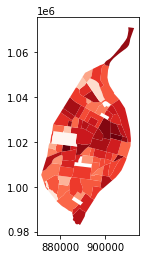

In [13]:
shape_entropy=l.entropy()

shape_entropy.to_file('SF_land_use_entropy.shp')

shape_entropy.plot(column="ENTROPY",cmap='Reds')

In [34]:
class stats(lum):
    
    def count(self):
        dataset = self.intermediate()[0]
        nuclapegrif=self.intermediate()[2]
        
        grid_count=(self.grid).merge(nuclapegrif,on = self.uid_grid)
        grid_count.rename(columns = {self.uid_lc:'COUNT'}, inplace = True)
        
        return grid_count
    
    def mode_count(self):
        dataset=self.intermediate()[3]
        dataset=dataset[[self.uid_lc,self.uid_grid]]
        
        mode_count=dataset.groupby([self.uid_grid]).agg(lambda x:x.value_counts().index[0])
        
        grid_mode_count=(self.grid).merge(mode_count,on = self.uid_grid)
        grid_mode_count.rename(columns = {self.uid_lc:'MODE_COUNT'}, inplace = True) 
        
        return grid_mode_count
    
    def mode_area(self):
        dataset=self.intermediate()[0][[self.uid_grid,self.uid_lc, "poly_area_x"]]
        mode_area=test.sort_values('poly_area_x',ascending=False).groupby(self.uid_grid).first()
        grid_mode_area=grid.merge(mode_area,on=uid_grid)
        grid_mode_area.rename(columns = {'poly_area_x':'AREA',self.uid_lc:'MODE_AREA'}, inplace = True)
        
        return grid_mode_area
    
    def report(self):
        dataset=self.lu
        dataset['AREA_sq_m']=dataset.area
        table=lu.groupby(self.uid_lc).describe()['AREA_sq_m']
        table=table.drop(columns=['25%','50%','75%'])
        
        return table

In [35]:
l=stats(lu,grid,uid_lc,uid_grid,temp_path)

In [36]:
l.report()

,count,mean,std,min,max
SLUP_LATES,,,,,
BIDA,361.0,329182.639617,1.254868e+06,2.009219,1.588894e+07
BIPA,367.0,444019.782178,1.215592e+06,1105.935478,1.410592e+07
IPDA,799.0,102798.303978,2.492438e+05,1407.714889,3.032426e+06
NCA,1006.0,50055.657359,5.690968e+04,477.943558,6.366094e+05
NDA,849.0,66676.893304,4.960400e+04,1655.659537,5.902240e+05
NPA,7027.0,75663.104202,8.227757e+04,52.990640,1.478795e+06
OA,255.0,108826.942432,1.966529e+05,1710.106437,1.984849e+06
RCA,65.0,335489.850671,4.560507e+05,19572.245151,2.402281e+06
ROSPDA,266.0,728875.410418,3.838155e+06,1.951731,5.451792e+07


In [20]:
layer_count=l.mode_count()

In [21]:
layer_count

,NHD_NUM,NHD_NAME,ANGLE,NHD_NUMTXT,NHD_NUM_ST,geometry,MODE_COUNT
0,43,Franz Park,0.0,43 Franz Park,43,"POLYGON ((877657.980 1016328.400, 877790.310 1...",NPA
1,29,Tiffany,0.0,29 Tiffany,29,"POLYGON ((895417.850 1016887.240, 894894.990 1...",IPDA
2,28,Botanical Heights,0.0,28 Botanical Heights,28,"POLYGON ((893871.830 1017297.510, 893519.400 1...",NPA
3,40,Kings Oak,0.0,40 Kings Oak,40,"POLYGON ((887474.710 1017871.670, 887462.870 1...",NPA
4,41,Cheltenham,0.0,41 Cheltenham,41,"POLYGON ((884617.940 1018220.450, 884356.350 1...",NPA
...,...,...,...,...,...,...,...
83,75,Riverview,0.0,75 Riverview,75,"POLYGON ((912850.520 1070608.750, 911152.090 1...",NPA
84,82,Forest Park,0.0,82 Forest Park,82,"POLYGON ((881688.670 1024668.290, 881627.990 1...",ROSPDA
85,47,DeBaliviere Place,0.0,47 DeBaliviere Place,47,"POLYGON ((883280.420 1026844.880, 884585.510 1...",NPA
86,46,Skinker DeBaliviere,0.0,46 Skinker DeBaliviere,46,"POLYGON ((881793.000 1027030.400, 881787.090 1...",NPA
